<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

import warnings
warnings.filterwarnings('ignore')

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

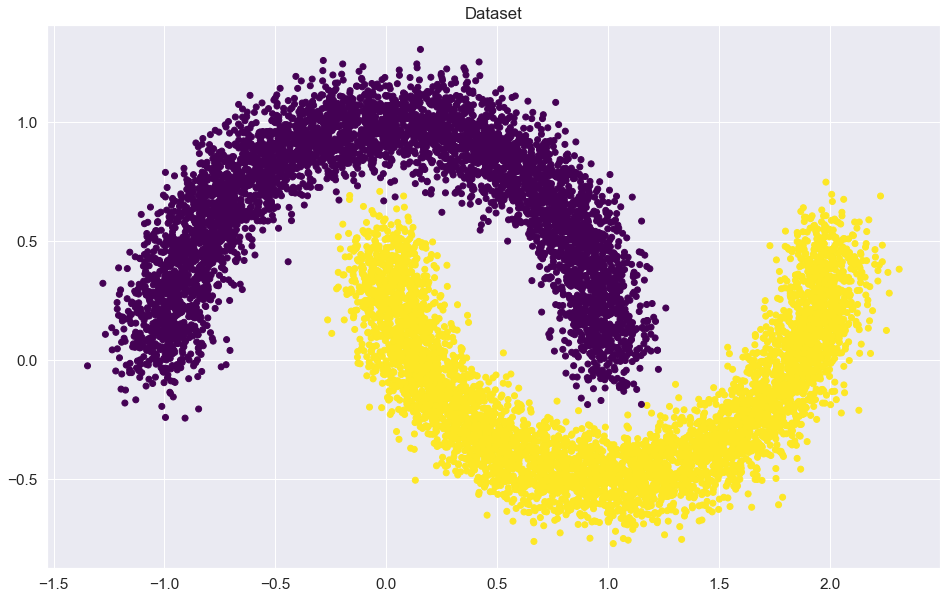

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
#зафиксируем наши результаты
np.random.seed(12345) 
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term 
        return x

In [13]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ: 3.**

Обучаемые параметры — это те, значение которых корректируется/изменяется во время обучения. 

В случае инициализации веса или смещения нормальным распределением torch.randn(in/out_features) количество обучаемых параметров - нейроны, заданные в параметре torch.randn(size = ). В нашем случае - 2 и 1. Это легко проверить, заменив количество входных и/или выходных нейронов на любое произвольное число.

In [14]:
summary(linear_regression)

Layer (type:depth-idx)                   Param #
LinearRegression                         3
Total params: 3
Trainable params: 3
Non-trainable params: 0

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [15]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        linear_regression.train()
          
        optimizer.zero_grad()
        
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4375
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9296875
Iteration: 400
Batch accuracy: 0.90625
Iteration: 500
Batch accuracy: 0.9375

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 579 (включая нулевую). 

### Визуализируем результаты

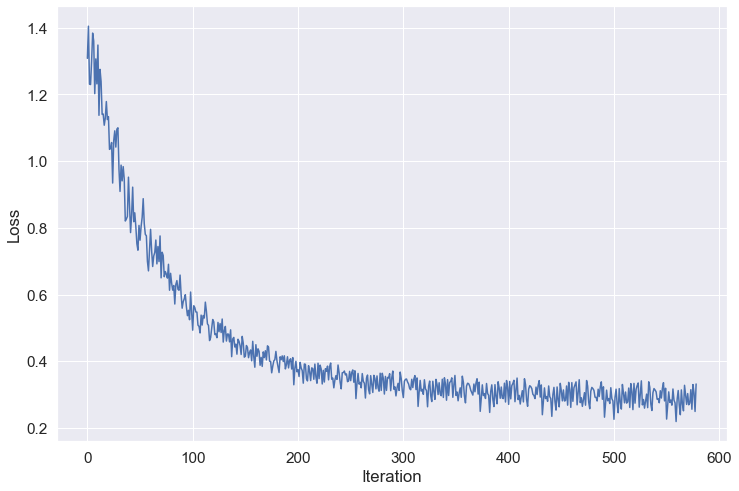

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

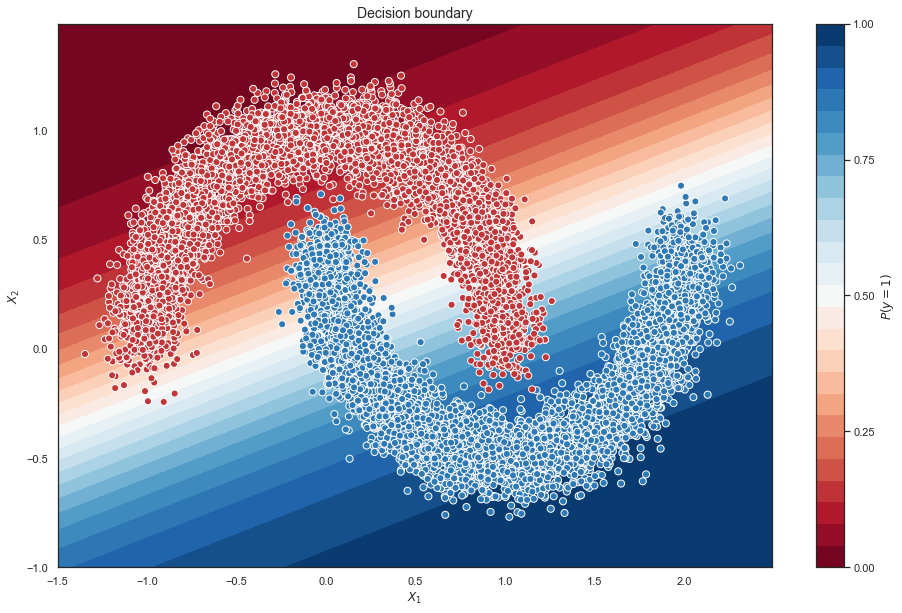

In [17]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    with torch.no_grad(): 
        for x_batch, _ in dataloader:
            outp = model.forward(x_batch)
            probabilities = torch.sigmoid(outp)
            preds = (probabilities > 0.5).type(torch.long)
            predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [19]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict(val_dataloader, linear_regression))
accuracy

0.8832

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0,8832

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [20]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=128, drop_last=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [21]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [22]:
dataiter = iter(train_dataloader)
features, labels = dataiter.next()
print(features.shape) #посмотрим размер призаков для определения входного слоя нейронов

torch.Size([128, 1, 28, 28])


In [23]:
loaders = {"train": train_dataloader, "valid": valid_dataloader}

n_in, n_hidden_1, n_hidden_2, n_out = features.shape[-1]*features.shape[-2], 128, 128, 10 #количество нейронов
criterion = torch.nn.CrossEntropyLoss()

In [24]:
def new_model(activation): #создает модель с заданными слоями активации
    
    if activation!=None: #если есть функция активации
        model = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(n_in, n_hidden_1),
                    activation,
                    nn.Linear(n_hidden_1, n_hidden_2),
                    activation,
                    nn.Linear(n_hidden_2, n_out),
                    nn.Softmax())   
       
    else:  #если нет функции активации
        model = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(n_in, n_hidden_1),
                    nn.Linear(n_hidden_1, n_hidden_2),
                    nn.Linear(n_hidden_2, n_out),
                    nn.Softmax())   
  
    optimizer = torch.optim.Adam(model.parameters())    
    
    return model, optimizer   

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [26]:
def funck_train_eval(model, optimizer, activation):
     
    for epoch in range(max_epochs):
       
        if activation == None: #запишем имя используемой функции активации
            accuracy['func_activation'].append('No activation')
        else:
            accuracy['func_activation'].append(activation.__class__.__name__) 
        accuracy['epoch'].append(epoch) #запишем номер эпохи
        
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()  
                    with torch.no_grad(): 
                        outp = model(x_batch) 
            
                preds = outp.argmax(-1)
                correct =  (preds.flatten() == y_batch).type(torch.float32).sum() #верных ответов в выборке
                all =  y_batch.size(0) #всего объектов в выборке
                epoch_correct += correct.item()
                epoch_all += all
            
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                
            #if k == "train":
                #print(f"Epoch: {epoch+1}")
            #print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}") 
            #уберем, чтобы не загромождать выход. Результаты посмотрим в итоговой таблице
            
            accuracy[k].append(epoch_correct/epoch_all)
            
    return accuracy


In [27]:
max_epochs = 10
accuracy = {"func_activation": [], 
            "epoch": [],
            "train": [], 
            "valid": []} #добавим в словарь указание функции активации и счетчик для эпохю Сюда мы будем записывать результаты

In [28]:
%%time
activation= nn.ELU()

model, optimizer = new_model(activation)
funck_train_eval(model, optimizer, activation)

pd.DataFrame.from_dict(accuracy)

Wall time: 2min 54s


,func_activation,epoch,train,valid
0,ELU,0,0.841613,0.889724
1,ELU,1,0.916349,0.922376
2,ELU,2,0.934913,0.938401
3,ELU,3,0.945580,0.947216
4,ELU,4,0.953943,0.935897
5,ELU,5,0.958066,0.959736
6,ELU,6,0.961455,0.956230
7,ELU,7,0.966329,0.953826
8,ELU,8,0.969067,0.963742
9,ELU,9,0.970202,0.956330


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
list_activation = [nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.Sigmoid(), None] #функции активации запишем в отдельный спикок

def test_activation_function(list_activation): #с помощью функции обучим модель используя разные функции активации
    for activation in list_activation:
        model, optimizer = new_model(activation)
        funck_train_eval(model, optimizer, activation)  

In [30]:
%%time

test_activation_function(list_activation)

df = pd.DataFrame.from_dict(accuracy)
df.loc[df['epoch']==max_epochs-1] #посмотрим результаты по последней эпохе

Wall time: 15min 54s


,func_activation,epoch,train,valid
9,ELU,9,0.970202,0.956330
19,LeakyReLU,9,0.968399,0.957031
29,Tanh,9,0.967264,0.948017
39,ReLU,9,0.964911,0.957732
49,Sigmoid,9,0.971221,0.956030
59,No activation,9,0.894531,0.895433


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [31]:
sns.set(style="darkgrid", font_scale=1.4)
def show_result(df): #Построим лайнплот для различных функций активации
    plt.figure(figsize=(14, 8))
    plt.title("Valid accuracy")
    sns.lineplot(data = df, x = 'epoch', y = 'valid', hue = 'func_activation')
    plt.legend()
    plt.show()

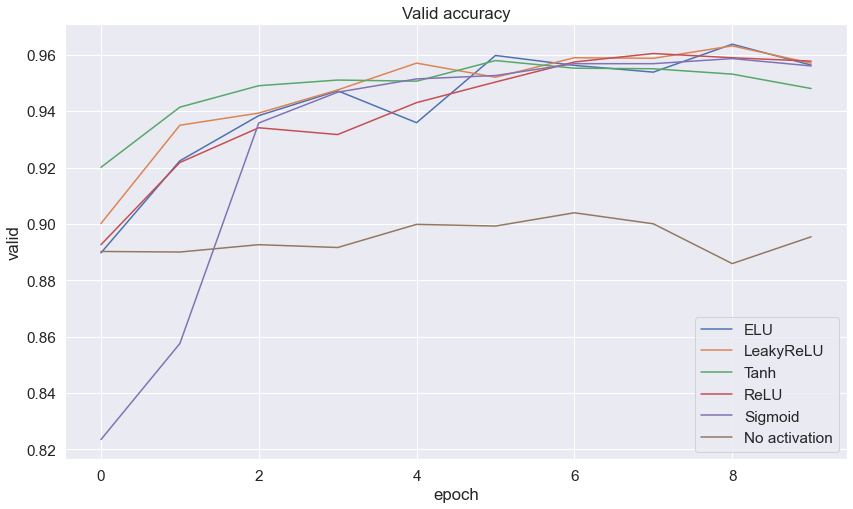

In [32]:
show_result(df)

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [33]:
import wget #загрузка картинок для Windows
url = 'https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg'
filename = wget.download(url)

100% [..........................................................] 49337 / 49337

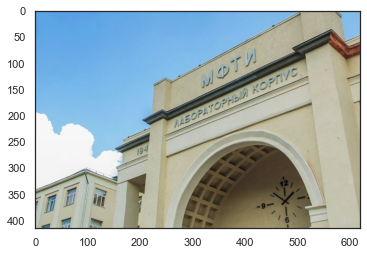

In [34]:
import cv2
sns.set(style="white")
img = cv2.imread(filename)

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 4))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [35]:
#запишем фильтры в список
list_kernel = [[[0, 0, 0],[0, 1, 0],[0, 0, 0]],
               [[0, 1, 0],[0, -2, 0],[0, 1, 0]],
               [[0, 0, 0],[1, -2, 1],[0, 0, 0]],
               [[0, 1, 0],[1, -4, 1],[0, 1, 0]],
               [[0, -1, 0],[-1, 5, -1],[0, -1, 0]],
               [[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]],
               [[0., 0., 0.],[0.0625, 0.125, 0.0625],[0., 0., 0.]],
               [[0.125, 0.25, 0.125],[1, 0.125, 1],[0.125, 0.25, 0.125]],
               [[0, 0, 0],[1, -2, 1],[0, 0, 0]]] 

In [36]:
#код, как у преподавателя, просто обернем его в функцию
def image_transform(kernel): 
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]
    return result.permute(1, 2, 0).numpy() / 256 / 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


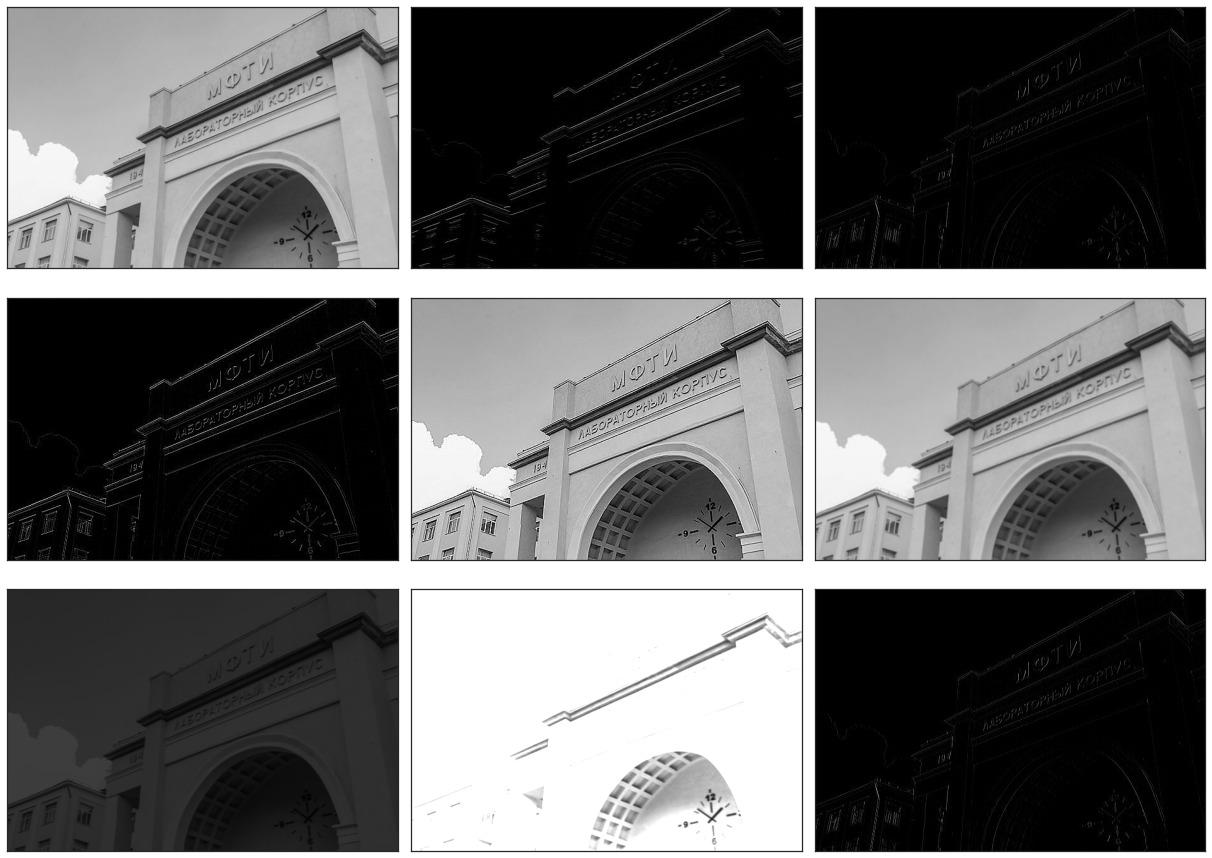

In [37]:
fig = plt.figure(figsize=(17,13))
for i, kernel in enumerate (list_kernel): #пробежимся к цикле по фильтрам
    image = image_transform(kernel)
    fig.add_subplot(3, 3, i+1)
    plt.imshow(image)
    plt.xticks([]) #уберем оси
    plt.yticks([]) #уберем оси
    plt.tight_layout()

In [38]:
#img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
#kernel = torch.tensor([
    #[[0, 0, 0],[1, -2, 1],[0, 0, 0]]]).reshape(1, 1, 3, 3).type(torch.float32)

#kernel = kernel.repeat(3, 3, 1, 1)
#img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
#img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

#result = F.conv2d(img_t, kernel)[0]  #

In [39]:
#plt.figure(figsize=(12, 8))
#result_np = result.permute(1, 2, 0).numpy() / 256 / 3

#plt.imshow(result_np)
#plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** E, Д, А, В, Б, Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, (3,3))
        self.conv2 = nn.Conv2d(6, 16, (3,3))
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
   

In [41]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [42]:
funck_train_eval(model, optimizer, activation = model)

df = pd.DataFrame.from_dict(accuracy)
df.loc[df['epoch']==max_epochs-1] #посмотрим результаты по последней эпохе

,func_activation,epoch,train,valid
9,ELU,9,0.970202,0.956330
19,LeakyReLU,9,0.968399,0.957031
29,Tanh,9,0.967264,0.948017
39,ReLU,9,0.964911,0.957732
49,Sigmoid,9,0.971221,0.956030
59,No activation,9,0.894531,0.895433
69,LeNet,9,0.993389,0.982873


Сравним с предыдущем пунктом

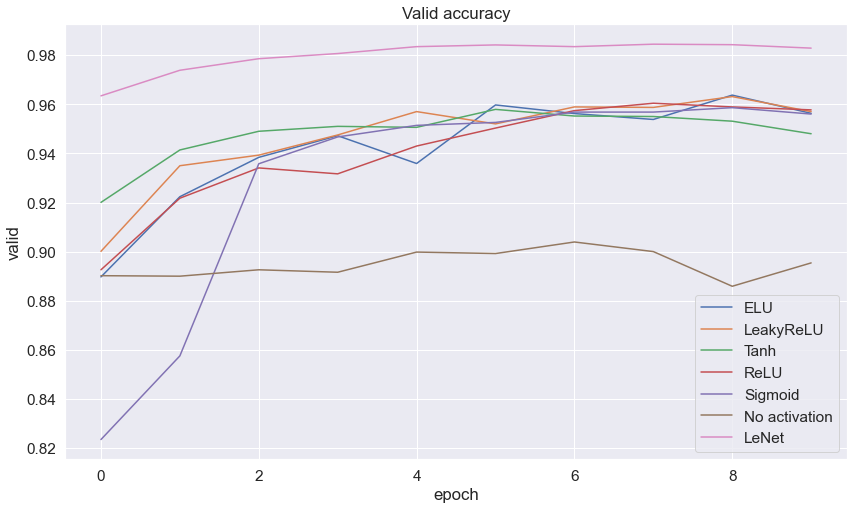

In [43]:
sns.set(style="darkgrid", font_scale=1.4)
show_result(df)

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** используя модель с архитектурой LeNet удалось добиться accuracy  = 0.98